# Source Catalog

Author: Bingcheng Jin

Date: 2023.12.31


## Table of Contents
* [Merge Images](#merge-images)
* [Source Detection](#source-detection)
  * [convolve](#convolve-image-with-guassian-kernel)
  * [apply detection](#apply-source-detection-and-deblend-with-photutils)
* [Assign SEGMAP](#assign-segmentationimage-to-merged-image)
* [Match](#match-sources)
* [Human check](#human-check)

In [30]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [54]:
img_name = 'nircam6'
img_dir = f'./io/image/{img_name}/'
img_list = glob.glob(f'{img_dir}*.fits')
img_list.sort()

## Merge Images

In [55]:
from utils.merge import merge_image

In [56]:
img_list

['./io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f115w_dr0.5_i2d.fits',
 './io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f150w_dr0.5_i2d.fits',
 './io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f200w_dr0.5_i2d.fits',
 './io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f277w_dr0.5_i2d.fits',
 './io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f356w_dr0.5_i2d.fits',
 './io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f410m_dr0.5_i2d.fits',
 './io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f444w_dr0.5_i2d.fits',
 './io/image/nircam6/merged.fits']

In [57]:
from astropy.wcs import WCS
image_merged_path = img_dir+'merged.fits'
if os.path.exists(image_merged_path):
    print('image_merged.fits already exists')
    with fits.open(image_merged_path) as hdul:
        image_merged = hdul['MERGED'].data
        w = WCS(hdul['MERGED'].header)
    print(f'Data are loaded from {image_merged_path}')
else:
    image_merged = merge_image(img_list[3:7])
    w = WCS(fits.getheader(img_list[1], extname='SCI'))
    hdr = w.to_header()
    hdr['EXTNAME'] = 'MERGED'
    fits.writeto(image_merged_path, image_merged, overwrite=True, header=hdr)        

image_merged.fits already exists
Data are loaded from ./io/image/nircam6/merged.fits


Set OBSGEO-B to   -36.864348 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725861996.312 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


## Source Detection

In [58]:
from astropy.stats import sigma_clipped_stats, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel, convolve
from photutils.segmentation import detect_sources

### determine threshold for detection

In [59]:
mean, median, std = sigma_clipped_stats(image_merged, sigma=3.0)
std

0.0026230087169823784

### convolve image with guassian kernel

In [60]:
# might take 40 seconds
fwhm = 4.0 # approaximate pixel FWHM of the NIRCam LW imaging PSF
sigma = fwhm * gaussian_fwhm_to_sigma # FWHM to sigma conversion
image_merged_conv = convolve(image_merged, Gaussian2DKernel(sigma))

### apply source detection and deblend with photutils

In [61]:
segm = detect_sources(image_merged_conv, threshold=1.0*std, npixels=5)

In [62]:
# might take 2-3 minutes
from photutils.segmentation import deblend_sources
segm_deblend = deblend_sources(image_merged_conv, segm, npixels=5)

Deblending:   0%|          | 0/24122 [00:00<?, ?it/s]

Compare with Sun et al. 2023

In [63]:
from photutils.segmentation import SegmentationImage
segm_wen = SegmentationImage(fits.getdata(f'../nircamsegm/{img_name}_seg.fits'))

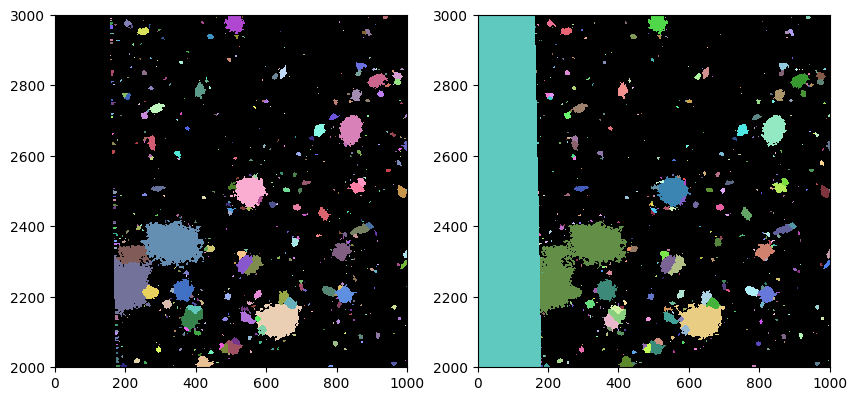

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
segm_deblend.imshow(ax=ax1)
ax1.set_xlim(0, 1000)
ax1.set_ylim(2000, 3000)
segm_wen.imshow(ax=ax2)
ax2.set_xlim(0, 1000)
ax2.set_ylim(2000, 3000)
plt.show()

## Assign SegmentationImage to merged image

total number of sources detected

In [65]:
segm_deblend.nlabels

39831

convolved image and segmentation map can be used later without doing steps above

In [66]:
hdr_segm = fits.Header()
hdr_segm['EXTNAME'] = 'SEGMAP'
hdr_conv = fits.Header()
hdr_conv['EXTNAME'] = 'SCI_BKSUB_CONV'
fits.append(image_merged_path, image_merged_conv, header=hdr_conv, overwrite=True)
fits.append(image_merged_path, segm_deblend.data, header=hdr_segm, overwrite=True)

## Match Sources

In [67]:
from photutils.segmentation import SourceCatalog
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

In [68]:
cat = SourceCatalog(image_merged_conv, segm_deblend,wcs=w, convolved_data=image_merged_conv)
src_tab = cat.to_table()
skycoord_list = src_tab['sky_centroid']

In [69]:
with fits.open('Stefanon2017.fit') as hdul:
    tab_ref = Table(hdul[1].data)
    tab_z = Table(hdul[2].data)
highz = np.where((tab_z['__photz_'] >= 4.0))[0]
tab_highz = tab_ref[highz]
len(tab_highz)

1960

In [70]:
ref_list = SkyCoord(ra=tab_highz['_RAJ2000']*u.degree, dec=tab_highz['_DEJ2000']*u.degree, frame='fk5').transform_to('icrs')

In [71]:
max_sep = 1. # arcsec
idx1, idx2, d2d, _= skycoord_list.search_around_sky(ref_list, max_sep*u.arcsec)

In [72]:
idx1_unique, pos_unique = np.unique(idx1, return_index=True)
tab_ref_matched = tab_highz[idx1_unique]
tab_src_matched = src_tab[idx2[pos_unique]]

In [73]:
tab_ref_matched = tab_highz[np.unique(idx1)]

## Human check 

In [74]:
match_dir = f'./io/match/{img_name}/'

In [75]:
# crossmatch check in csv format, convienient for human check
tab_ref_matched.keep_columns(['_RAJ2000','_DEJ2000','Seq'])
tab_ref_matched.rename_column('_RAJ2000', 'RA')
tab_ref_matched.rename_column('_DEJ2000', 'DEC')
tab_ref_matched.add_column(tab_src_matched['label'], name='label')
tab_ref_matched.write(match_dir + f'tab_ref_matched_{img_name}.csv', format='ascii.csv', overwrite=True)

### prep for ds9 catalog (Optional)

In [76]:
"""
# for SAO DS9 reference catalog
tab_ref_matched.write(match_dir + f'tab_ref_matched_{img_name}.fits', overwrite=True)

# for SAO DS9 catalog
fits.writeto(match_dir + f'{img_name}_merged.fits', image_merged, overwrite=True, header=w.to_header())
# for SAO DS9 catalog
skycoord_list_matched = skycoord_list[idx2]
tab_matched = Table()
tab_matched.add_column(src_tab[idx2]['label'], name='label')
tab_matched.add_column(skycoord_list_matched.ra, name='ra')
tab_matched.add_column(skycoord_list_matched.dec, name='dec')
tab_matched.write(match_dir + f'tab_matched_{img_name}.fits', overwrite=True)
"""

"\n# for SAO DS9 reference catalog\ntab_ref_matched.write(match_dir + f'tab_ref_matched_{img_name}.fits', overwrite=True)\n\n# for SAO DS9 catalog\nfits.writeto(match_dir + f'{img_name}_merged.fits', image_merged, overwrite=True, header=w.to_header())\n# for SAO DS9 catalog\nskycoord_list_matched = skycoord_list[idx2]\ntab_matched = Table()\ntab_matched.add_column(src_tab[idx2]['label'], name='label')\ntab_matched.add_column(skycoord_list_matched.ra, name='ra')\ntab_matched.add_column(skycoord_list_matched.dec, name='dec')\ntab_matched.write(match_dir + f'tab_matched_{img_name}.fits', overwrite=True)\n"